# Numerical optimization

The exact solutions obtained using the Lagrange multiplier method work well with a fixed number of linear equality constraints, such as the budget constraint 
$\sum w_i=1$ that portfolio weights sum to one.  However the individual components of the weight vector are completely unconstrained.  Nothing prevents negative weights, $w_i <0$, which represent short positions, or large absolute values (e.g. $w_k = 3$), which represent highly leveraged positions.

Real-world investment mandates almost always have *inequality* constraints to prevent impermissible or unreasonable capital allocations.
In that case, numerical techniques solve for the optimal portfolio.  A frequently encountered constraint is \(w_i \ge 0\), which means that **short** positions are not allowed.  Constraints may apply at the level of individual weights (e.g., concentration limits such as $w_i \le 0.15$) or across potential sub-portfolios (e.g., risk limits for exposure to factors).  Quadratic programming handles these cases simultaneously.


### A note on what is new what is not.

The first section of this notebook (Example:  Global Asset Allocation) is a simple copy of R notebook, porting the R code to Python. The notebook is from the MIT Micro Masters in Finance (MITx 15.455x - Mathematical Methods for Quantitative Finance).

The second part (The efficient frontier in the presence of inequality constraints) is a complete rewrite of the same notebook but in Python. The rewrite was necessary since the Python module and the R modules have a very different interface. Also, I added a few more explanation steps to simplify extending the code if necessary.

Finally, the third section (Example: Portfolio Optimization with transaction costs) is from a medium article that was helpful in writing this notebook.

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
import pandas as pd
import seaborn as sns
import numpy as np

import pandas as pd
import seaborn as sns
import numpy as np


In [13]:
data = pd.read_csv("data/michaud.csv")
data = data.rename(columns={"Unnamed: 0":"Asset"})

In [30]:
# If you need to load the data from the notebook itself: 

_columns = "Asset,Canada,France,Germany,Japan,UK,US,US Bonds,Euros,Unnamed: 9,Unnamed: 10,Mean,SD,Index,Current"
_data_raw = """Canada,1.0,0.41,0.3,0.25,0.58,0.71,0.26,0.33,0.0097,0.0547,0.0039,0.055,0.05,0.05
France,0.41,1.0,0.62,0.42,0.54,0.44,0.22,0.26,0.0146,0.07,0.0088,0.0703,0.1,0.1
Germany,0.3,0.62,1.0,0.35,0.48,0.34,0.27,0.28,0.0111,0.0619,0.0053,0.0622,0.1,0.0
Japan,0.25,0.42,0.35,1.0,0.4,0.22,0.14,0.16,0.0146,0.0701,0.0088,0.0704,0.3,0.2
UK,0.58,0.54,0.48,0.4,1.0,0.56,0.25,0.29,0.0137,0.0599,0.0079,0.0601,0.1,0.15
US,0.71,0.44,0.34,0.22,0.56,1.0,0.36,0.42,0.0129,0.0428,0.0071,0.043,0.35,0.2
US Bonds,0.26,0.22,0.27,0.14,0.25,0.36,1.0,0.92,0.0083,0.0199,0.0025,0.0201,0.0,0.2
Euros,0.33,0.26,0.28,0.16,0.29,0.42,0.92,1.0,0.0085,0.0152,0.0027,0.0156,0.0,0.05"""

# uncomment the next line if you are loading the data from this notebook
data = pd.DataFrame([r.split(",") for r in _data_raw.split("\n")], columns=_columns.split(","))

# adjyst types:
columns = data.columns[1:]
for c in columns:
  data[c] = data[c].apply(float)
  

# Example:  Global Asset Allocation

Mean-variance optimization is not limited by the number of independent assets.  However it is most effective when the number is relatively small, with sufficient data to adequately estimate the parameters.  To obtain estimates for a 500x500 covariance matrix of monthly returns requires $T \gg 500$ observations.  At best, that means the model is relying on very old data; and typically, it means that many estimation and numerical errors may enter the process.

Let's explore a concrete case using just eight assets, using a numerical example provided by Richard Michaud in his book "Efficient Asset Management."  We compute the various algebraic quantities derived in class, and plot the correlations and return vs. risk of the individual assets.

In [72]:
sigma = np.matrix(data["SD"].values.reshape(-1,1))
mu = np.matrix(data["Mean"].values).reshape(-1,1)

corr = data.loc[:,"Canada":"Euros"]
corr = np.matrix(corr)
cov = np.matrix(np.diag(data["SD"])) * corr * np.matrix(np.diag(data["SD"]))
inv_cov = np.linalg.inv(cov)

iota = np.matrix(np.ones((len(cov),1))) # len(cov) = 8

In [73]:
a = float(iota.T * inv_cov * iota)
b = float(iota.T * inv_cov * mu)
c = float(mu.T * inv_cov * mu)

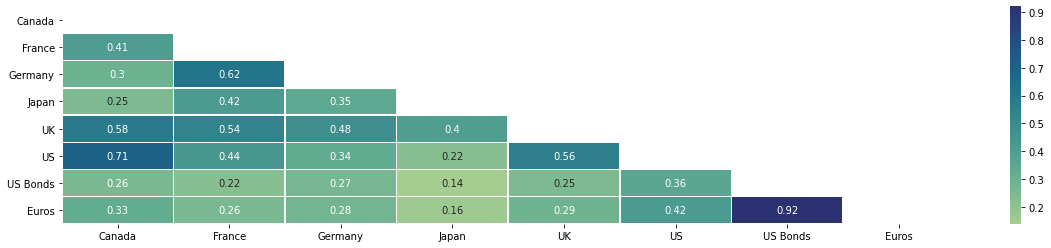

In [74]:
matrix = np.triu(corr)
_ = sns.heatmap(
  corr,
  annot=True,
  linewidth=.5,
  cmap="crest",
  yticklabels=data["Asset"],
  xticklabels=data["Asset"],
  mask=matrix
)


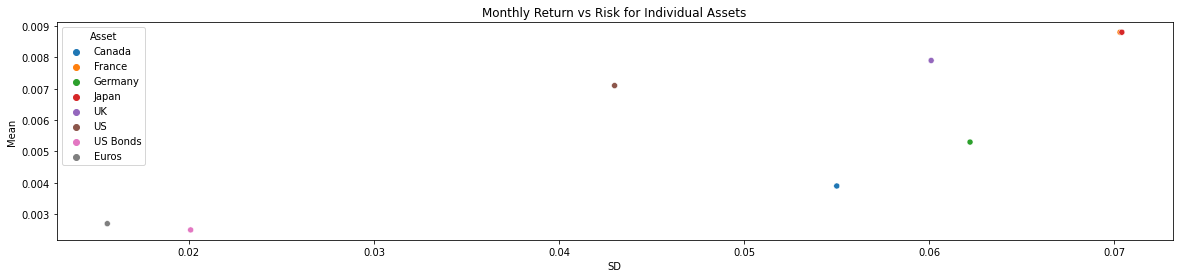

In [75]:
sns.scatterplot(x="SD", y="Mean", data=data, hue="Asset")
_ = plt.title("Monthly Return vs Risk for Individual Assets")

## Mininum Variance Portfolio

In [76]:
wchar_exp = inv_cov * iota / sum(inv_cov * iota)
wchar_mu = inv_cov * mu/ sum(inv_cov * mu)

In [77]:
pd.concat(
  [
    pd.DataFrame(wchar_exp, columns=["wchar_exp"]),
    pd.DataFrame(wchar_mu, columns=["wchar_mu"])
  ],
  axis=1
)

,wchar_exp,wchar_mu
0,-0.016915,-0.207033
1,-0.013432,0.040832
2,0.003889,-0.040714
3,0.019205,0.086539
4,-0.000775,0.064736
5,-0.014564,0.283161
6,-0.652527,-0.847485
7,1.675119,1.619965


# The efficient frontier in the presence of inequality constraints

Most investment problems have inequality constraints in addition to equalities like the budget constraint.  For instance, a "no short position" rule requires that individual weights all be non-negative -- something that cannot be guaranteed in the exact, closed-form solution derived using Lagrange multipliers.

To find the mean-variance efficient frontier in the presence of a "no short, no leverage" rule, we will build a function utilizing the `cvxopt` (convex optimization) module to do the job.


In [78]:
# !pip install cvxopt

Our goal is to minimize the following loss function $\mathcal{L}$, with the :

$$\mathcal{L}(x) = \frac{1}{2} x^TQx - r^Tx \\
\text{ Subject to } \begin{cases} 
      Gx \preceq h \\
      Ax = b\\
   \end{cases}$$

Where $Q$ is the matrix of covariances of assets, $r$ is the expected asset return, and $\preceq$ is the inequality element-wise.


For more details on how python and `cvxopt` handles this the [documentation](https://cvxopt.org/userguide/coneprog.html#cvxopt.solvers.coneqp).

A great intro post about `cvxopt` can be found in this medium [link](https://towardsdatascience.com/quadratic-optimization-with-constraints-in-python-using-cvxopt-fc924054a9fc).

In [79]:
import cvxopt as opt
from cvxopt import matrix
from cvxopt.solvers import qp, options

These are the constraints we are going to impose in this optimization:

```python
# (1) Budget: sum of weights = 1 (first column)
# (2) Return: portfolio return constrained to have mean return Mu

# (3) Lower bound: individual weights > 0
# (4) Upper bound: individual weights < 1
```

The idea is to find the set of weights (x) that minimize the risk (standard deviation) for a certain level of returns, with the added constraint that we are not allowed to short stocks (individual weights > 0) or take leverage (individual weights < 1).

In [80]:
n = len(mu)

In [81]:
# (1) Budget: sum of weights = 1 (first column)
# (2) Return: portfolio return constrained to have mean return Mu
A = np.block([
  [np.ones(n)],
  [np.array(mu).flatten()]
  ]
)
print(A)
A = opt.matrix(A)

[[1.     1.     1.     1.     1.     1.     1.     1.    ]
 [0.0039 0.0088 0.0053 0.0088 0.0079 0.0071 0.0025 0.0027]]


**Note** that the constraint $Gx \preceq h$ will be 
$\begin{pmatrix}
-I_n\\
I_n
\end{pmatrix}$, where $I_n$ is the identity while the negative sign is necessary due to the fact that the constraint is using the $\preceq$, hence, asking the weights to be all positives is equivalent to asking that the weights satisfy: $-x_i \leq 0, \forall i$.

In [82]:
# (3) Lower bound: individual weights > 0
# (4) Upper bound: individual weights < 1
G = np.block(
  [
    [-np.eye(len(mu))], 
    [np.eye(len(mu)) ],
  ] 
)
print("G:\n", G)
G = matrix(G)
h = np.block([
  np.zeros(len(mu)),
  np.ones(len(mu)),
])
print("h:\n", h)
h = opt.matrix(h)

G:
 [[-1. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -1. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -1. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]
h:
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [258]:
nsamples = 100

Q = opt.matrix(cov)

epsilon = 0.0001 # for rounding endpoint values (solution might not be feasable otherwise)
mu_min = min(mu) + epsilon*(np.mean(mu) - min(mu))
mu_max = max(mu) + epsilon*(max(mu) - np.mean(mu))
mu_p = np.linspace(float(mu_min), float(mu_max), nsamples)

sols = {}
ROWS = []

options['show_progress'] = False
for k in range(len(mu_p)):
  r = matrix(np.ones(len(mu))*mu_p[k])
  b = matrix([1.0, mu_p[k]])
  # https://cvxopt.org/userguide/coneprog.html#quadratic-programming
  sols[k] = qp(Q, -r, G, h, A, b)
  sol = sols[k]
  solution = np.array(sol["x"].T)
  optimal_return = opt.blas.dot(sol["x"], r)
  optimal_risk = opt.blas.dot(sol["x"], Q * sol["x"])
  
  ROWS.append((mu_p[k], solution, optimal_return, optimal_risk))
  


In [259]:
df = pd.DataFrame(
  ROWS, 
  columns=["mu_p[k]", "solution","optimal_return", "optimal_risk"]
)

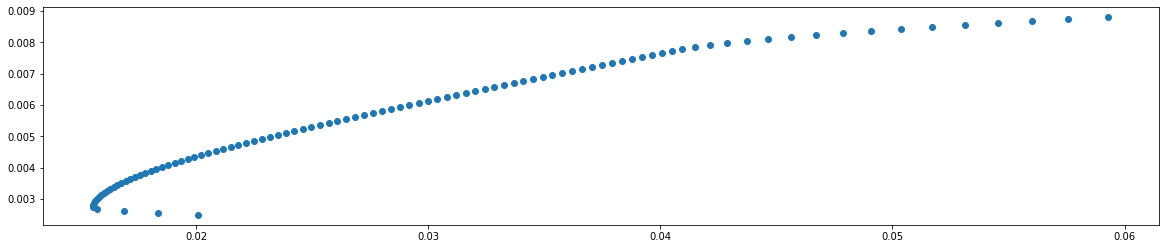

In [260]:
plt.scatter(np.sqrt(df.optimal_risk), df.optimal_return)

(from the R notebook:)

For comparison, consider the unconstrained frontier.  In class, we derived the analytical form for the efficient frontier when there were only global budget constraints, without restrictions on the individual weights.  The blue line below shows the that curve.  The area between the blue and the black frontiers represent portfolios that are only feasible when individual short positions and leverage are permitted.   The original assets are shown as the red points, which can also be thought of as highly concentrated portfolios.

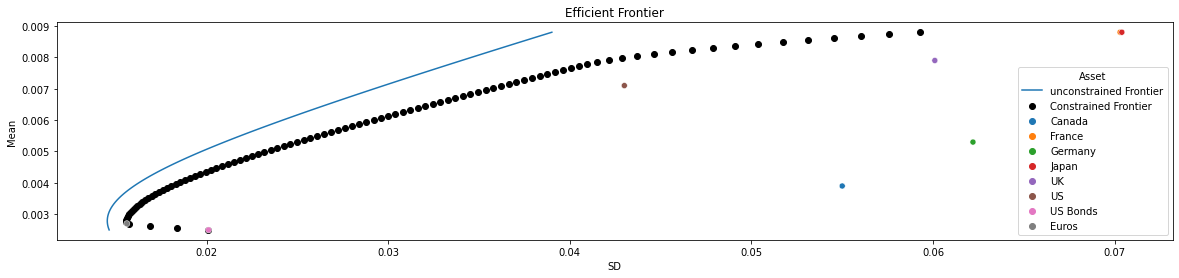

In [261]:
a = float(iota.T * inv_cov * iota)
b = float(iota.T * inv_cov * mu)
c = float(mu.T * inv_cov * mu)

# Use analytical results to get explicit closed-form hyperbola envelope function
y = df.optimal_return
x = np.sqrt((a*y**2 - 2*b*y + c)/(a*c-b**2))
plt.plot(x,y, color="tab:blue", label="unconstrained Frontier")
plt.scatter(
  np.sqrt(df.optimal_risk),
  df.optimal_return, 
  color="black",
  label="Constrained Frontier"
)
sns.scatterplot(x="SD", y="Mean", data=data, hue="Asset", ax=plt.gca())
_ = plt.title("Efficient Frontier")


# How the portfolios looks like

In [262]:
_rows = []
columns=data.loc[:,"Canada":"Euros"].columns
for row in df["solution"].apply(lambda x:list(x[0])):
  _rows.append( (*row,))

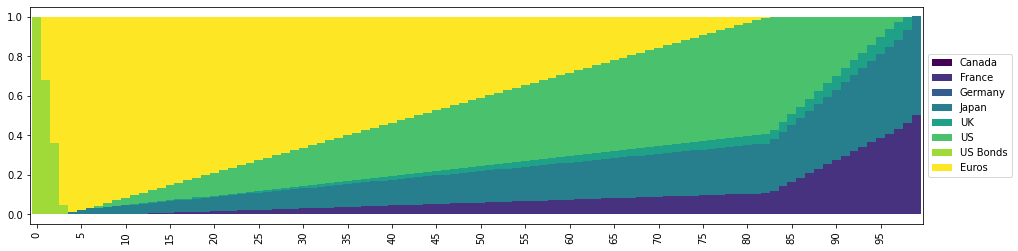

In [288]:
pd.DataFrame(_rows, columns=columns).plot(
  kind="bar",
  stacked=True,
  colormap='viridis',
  width=1,
)
# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
xticks = plt.xticks(xticks[0][::5])


# Example: Portfolio Optimization with transaction costs

As an interesting example of quadratic optimization, let's consider an example where the transaction costs are taken into account. The idea is that a rebalance would be done, only if the returns gained from the rebalance is greater than the costs inccurred. 

This example is taken from: https://towardsdatascience.com/quadratic-optimization-with-constraints-in-python-using-cvxopt-fc924054a9fc


The loss function we are minimazing is given by $$\mathcal{L}(x_t) = -x_t^T r_t + \frac{\lambda}{2} x_t^T C x_t + |x_t - x_{t-1}|\cdot c$$


Se the result below (for details see link in the above)

With the following constraints:

![1_D5wPDBlmuUW5LhniXX0eRw.jpg](1_D5wPDBlmuUW5LhniXX0eRw.jpg)

The constraints above lead to the following matrices and vectors:

![1_c-fJB4odRhVVsaTKVcckLA.png](1_c-fJB4odRhVVsaTKVcckLA.png)

In [5]:
import numpy as np
import cvxopt as opt
from cvxopt import matrix
from cvxopt.solvers import qp, options

In [9]:
#%%time

# Loss Function
n_assets_r = 20
n = 200
c = 0.001
max_weight = 0.05
r = opt.matrix(np.block([np.random.sample(n), -c * np.ones(2*n)]))
# Constraint matrices and vectors

A = opt.matrix(
  np.block(
    [
      [np.ones(n), c * np.ones(n), -c * np.ones(n)],
      [np.eye(n), np.eye(n), -np.eye(n)]
    ]
  )
)
old_x = np.zeros(n)
old_x[np.random.choice(n, n_assets_r, replace=False)] = max_weight
b = opt.matrix(np.block([1.0, old_x]))

max_weight = 0.05
turnover = 2.0
# Q matrix such that it resembles the covariance matrix of returns
T = np.random.randn(n,100)
Q = np.cov(T)
Q = opt.matrix(
  np.block(
    [
      [Q, np.zeros((n,n)), np.zeros((n,n))],
      [np.zeros((n,n)), np.zeros((n,n)), np.zeros((n,n))],
      [np.zeros((n,n)), np.zeros((n,n)), np.zeros((n,n))]
    ]
  )
)
# Create constraint matrices
G = opt.matrix(0.0, (6 * n + 1, 3 * n))
h = opt.matrix(0.0, (6 * n + 1, 1))
for k in range(3 * n):
    # wi > 0 constraint
    G[k, k] = -1
    # wi > max_weight
    G[k + 3 * n, k] = 1
    h[k + 3 * n] = max_weight
for k in range(2 * n):
    # sum dwi+ + dwi- < turnover
    G[6 * n, k + n] = 1
    
h[6 * n] = turnover

# Compute random portfolios in order to have a baseline
n_random = 100
random_returns = np.zeros(n_random)
random_risks = np.zeros(n_random)

options['show_progress'] = False
for i in range(n_random):
    w0 = np.zeros(n)
    w0[np.random.choice(n, n_assets_r, replace=False)] = 1 / n_assets_r
    random_returns[i] = np.dot(w0, r[:n])
    random_risks[i] = np.dot(w0, np.dot(Q[:n,:n], w0))
# Compute the optimal portfolio for different values of lambda, the risk aversion
lmbdas = [10 ** (5.0 * t / n - 1.0) for t in range(n)]
sol = [qp(lmbda / 2 * Q, -r, G, h, A, b)['x'] for lmbda in lmbdas]
optimal_returns = np.array([opt.blas.dot(x, r) for x in sol])
optimal_risks = np.array([opt.blas.dot(x, Q * x) for x in sol])

Now we can plot the result. See below the blue dots representing the threshold between feasiable and unfeasible portfolios, where the blue dots themselves represent the optimal portfolios given a certain level of risk and returns.

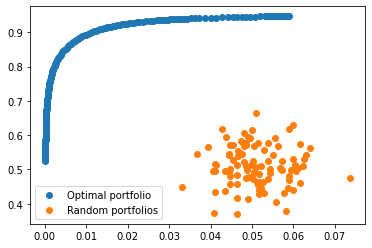

In [11]:
import matplotlib.pyplot as plt
plt.scatter(optimal_risks, optimal_returns, label="Optimal portfolio")
plt.scatter(random_risks, random_returns, label="Random portfolios")
_ = plt.legend()

# Discussion

In this notebook we saw how the input should look like to an optimization problem (covariance matrix, expected returns, etc). This is pretty much the role of the quant. Once that step is done, we can write our problem and constraints as a clever combination of equailities and inequalities to represent our problem. 

We also learned how to use th `cvxopt` module and how to write the input matrices and vectors in the correct form. 

Finally, we were able to interpret the results and their plots.